# Value Function Iteration (VFI)

This notebook is intended to serve as an introduction to using VFI to solve recursive dynamic economic models. I assume that you already know the deterministic neoclassical growth model and have been exposed to dynamic programming, so today's focus will solely be on writing code to find numerical solutions. Throughout my exposition, I will try to explain as many `non-obvious' lines of code or choices as possible, with an emphasis on what practical issue(s) they address or will address when the problem becomes more challenging.

# 0. Introduction

To fix notation and ground ideas, here is the deterministic neoclassical growth model which the following code will be solving. The social planner's problem is characterized by the following Bellman equation:
$$
V(k) = \max_{\left\{k^{\prime}\right\}} \left\{u(c) + \beta V(k^{\prime})\right\},
$$
subject to:
$$
c + k^\prime = f(k)
$$
where $u(c) = \log(c), f(k) = k^\alpha$, where $0 < \alpha < 1$.

Our goal is to find the value function $v(k)$ and the policy function for next period's capital, which I will denote as $k^\prime = g(k)$ (once we know g(k), we can back out the policy function for consumption via the resource constraint).

I use these functional forms and parameter values (note that $\delta = 1$ implicitly) because this parameterization lends itself to an analytical solution from Ljungqvist and Sargent (2018) with which we can verify our numerical solution against: 
$$
v^*(k) = \frac{\ln(1-\alpha\beta)}{1-\beta} + \frac{\alpha + \ln(\alpha\beta)}{1-\alpha}\left[\frac{1}{1-\beta} - \frac{1}{1-\alpha\beta} \right] + \frac{1}{1-\alpha\beta}\ln(f(k))
$$
and
$$
g^*(k) = \alpha\beta f(k)
$$
Of course, this analytical benchmark disappears the moment we depart from this parameterization. However, this setting is still extremely useful because it hits the complexity sweet spot of being just simple enough to have an analytical solution while also being complex enough to trial complicated numerical solution methods against. When learning new computational tools or algorithms I also find this to be a helpful sanity check for confirming whether I am using the new method correctly or not.

# 1. Initialization

First, we need to load all the packages and initialize all the objects that we will be using throughout the rest of the code. This includes our parameters (both economic and numerical) and functions.

In [1]:
using Interpolations
using Optim
using LinearAlgebra
using Plots

const β = 0.96
const α = 0.4

f(k) = k^α
u(c) = c ≥ 0.0 ? log(c) : -1e10

u (generic function with 1 method)

Note that I am declaring the parameters in an interpreted way, i.e. everything is declared line-by-line. For interpreted languages like MATLAB and Python, this is what we would do anyway. However, Julia is a compiled language, which means that the overwhelming majority of our code should be written in a function or housed inside a struct. Since I am prioritizing expository clarity and performance is not crucial here, this is fine for now, but just know that there are much better ways to do this.

Declaring our parameters to be a constant is not strictly necessary either. However, it is a minor optimization because it tells Julia's compiler that this parameter will not change.

## 1.1 Utility function

You may be wondering why the utility function is written this way. In Julia, this is called the **tenery operator** and it reads as the following: 

"Evaluate the statement to the left of the ?. If the statement (consumption is weakly positive) is true, then return what is to the left of the colon ($log(c)$). If it's false, return what is to the right of the colon (an arbitrary, but very negative number)".

When applying the maximization step later on, this function is very useful over simply writing $u(c) = \log(c)$ because it addresses two practical issues: stability and economic feasibility.

Obviously, it is not possible to take the log of a negative number (and when using the CRRA utility function, taking the exponent of a negative number yields complex numbers). Most optimizers economists use are iterative, meaning that the algorithm will iteratively apply guesses until a convergence criteria is met. If you are using unconstrained optimization, there is nothing that forces the algorithm to **trial** a solution that implies negative consumption. This would then result in your code crashing completely. Creating this custom function which is also defined over negative numbers prevents this unstable behavior from happening. 

Moreover, consider a scenario where your utility function is mathematically defined over negative numbers, yet economics naturally enforces negative consumption to be impossible. To safeguard against the optimizer actually **outputting** a choice that requires negative consumption, I define the utility function to output a number that is so large in magnitude that the optimizer would never make that choice. The optimizer may still attempt it, but it will be attached with such a large penalty such that these choices will never appear as the solution in equilibrium.

If tenery operators are not available in your preferred programming language, a custom function with an if-statement should work as well.

## 1.2 Creating the state-space (grid)

Next, we create our state-space. In principle, $k \in \mathbb{R}^{+}$, i.e. the state-space is continuous with infinitely-many elements. However, it is impossible to store infinitely many numbers on a computer, much less perform complex, non-linear operations on. In practice, we substitute this with a discrete grid of points (with finitely many elements) which in this case, is vector of capital points from 0.0 to 100.0 with 501 elements.

At the end of all this, we still won't know what the true value and policy functions are at every single point in their domain. The hope is that we get a approximately correct mapping at enough points such that the resulting function is close-enough to their true counter-parts in practice.

In [2]:
const kmin = 1e-3;
const kmax = 100.0;
const nk = 1_001;
const kgrid = range(kmin, kmax, length=nk)

0.001:0.099999:100.0

There are three extremely important numerical issues to consider. The answer to all of them are heavily context-dependent and practically impossible to know without alot of experimentation. I will still try to give some heuristics/explain how to think about them though.

### 1.2.1 How many gridpoints we should use?

There is a trade-off when deciding how many gridpoints to use. If *too few* gridpoints are used, then it becomes difficult to find an accurate solution (especially if the state space is completely discretized - more on this below). However, we wouldn't want to use *too many* gridpoints either, because it would dramatically increase the computational cost (and memory) needed for each iteration. In our one-dimensional model today, this would not be an issue on modern hardware, but since the number of gridpoints increases *exponentially* with the dimensionality of the state-space, we also need to be wary against too many gridpoints. 

Heuristically, the goal is to use the lowest number of gridpoints that delivers your desired level of accuracy (which is extremely context-dependent). Personally, I start with what I believe would be too many points and then slowly decrease it until the outputted value and policy functions start changing significantly. (It's also important to experiment with increasing it too to make sure that the solution is robust in that direction too!)

### 1.2.2 How wide should our bounds be?

Again, there is a trade-off associated with this choice. Making it *too narrow* means that at best, we would not accurately capture the model's dynamics while at worst, we would not find convergence at all. Making it *too wide* is also unideal because for the same number of gridpoints, the space between them would increase, and the accuracy of our solution would suffer (unless more gridpoints are used, which increases time-to-compute). 

Fortunately, models sometimes bless us with natural limits. For example, negative capital is not possible, so setting the lower bound to zero or close to zero is a good choice. Here, setting kmin to 0.0 results in terrible numerical instability (what is the log of 0?), so we will have to settle for a number close to 0.

Here, the upper-bound is less obvious. Sometimes, economics can give guidance. For instance, in this problem where a unique steady-state exists, any grid that does not include the steady-state value of capital would likely result in a terrible approximation. On the flip-side, the upper-bound likely wouldn't need to be significantly larger than this. This is a parameter worth playing around (there are literatures where the numerical results are **highly** sensitive to this), but like before, you can be confident that your grid is wide enough when enlarging it stops resulting in the results changing.

### 1.2.3 How should we space our points out across the bounds?

In this code (and most introductory code), the gridpoints are uniformly spread out. In low dimensional and well-behaved environments like this, this is fine since increasing the number of grid-points is not likely to be overly expensive. However, this is not **optimal**, and if your state-space is high dimensional (in practice, 3 dimensions) or your desired functions are nasty (e.g. it has kinks, discontinuities, or regions of high curvature), equidistant-spaced grids become outright prohibitively expensive. 

For a given finite budget of gridpoints, they should be concentrated around regions where the function is badly behaved because more gridpoints are needed to capture this behavior and increase your solution's accuracy. In scenarios where performance becomes critial, this is a worthwhile issue to experiment with.

## 2. Bellman operator
Now that we have initialized all our parameters, auxiliary functions and created the state space, the only thing left to do before putting everything togeter into an iterative loop is to create a function for the Bellman operator. 

The function performs the following steps:
1. Inputs the previous guess of the value function (a vector of the guessed value function evaluated at the corresponding points in the state space is).
2. Transforms that discrete set of guesses into a continuous function by interpolating between the grid and the guess via linear splines.
3. Applies the maximization step at each point in the grid. (Optim.jl's optimize function is used to find the **minimum** of functions. Thus, to find the **maximum**, we transform our problem by taking the negative of everything.)
4. For each $k$, the results of each maximization step is stored in an object called results, which houses the maximized value, and the maximizer. Store these in the appropriate pre-defined vector. 
5. Outputs the new value function $T(v)$ (after applying one iteration of the Bellman operator).

### Aside - interpolation vs discrete state space (DSS)
Most introductions to VFI are done with a purely discretized state-space with no interpolation at all. The main difference that this results in is that the later maximization step gets replaced with a grid-search. I.e. instead of using optimizers on a continuous function, we instead evaluate the objective function along a finite number of possible choices and pick the choice that results in the largest number. There are two major benefits to the DSS approach:
1. **Simplicity** - finidng the maximum among a row with finitely-many elements is much simpler (and possibly faster) than invoking optimizers. 
2. **Stability** - a significant source of instability for interpolation is that algorithms usually want to engage in **extrapolation**, especially at the boundaries of the grid. Extrapolation can result in extreme instability since there are no economic conditions to impose in the extrapolated region by construction. There are ways to side-step this, but they introduce risks.

However, there are also some major downsides to this approach (and ultimately why I prefer to teach VFI with interpolation)
1. **Speed/accuracy** - holding the desired level of accuracy constant, DSS requires far more gridpoints for the result of the maximization step to not be the result of **rounding error**. Suppose that the true optimal choice for $k^\prime$ at $k = 20.0$ is $k^\prime = 15.4$, but your grid is only defined on $...15.0, 16.0, ...$. Purely discretizing the state space will result in $k^\prime = 15.0$ being chosen, as it is the local maxima among a finite set of points - the value function isn't defined at $15.4$! You would need to increase the fineness of your grid to avoid that $0.4$ rounding error, thereby increasing computational cost. Meanwhile, interpolating between gridpoints results in the value function being defined at 15.4, even if your gridpoints are defined on $...10.0, 20.0...$. (This doesn't mean that there aren't any approximation errors though! E.g. your choice of basis functions might result in 15.35 being chosen as the optimum.)
2. **Speed** - VFI is very slow, especially if your state-space is high dimensional. (This is irrespective of whether you interpolate your desired functions or not.) I will go over algorithms that are MUCH faster (and more accurate) in future notebooks, but they only work with fully continuous functions, which DSS does not permit.

This is arguably the most important part of the code, so make sure you understand it!

In [3]:
function bellman_operator(vguess_V::Vector{Float64})
    vguess_F = LinearInterpolation(kgrid, vguess_V)
    Tv_V = zeros(length(kgrid))
    pol_V = zeros(length(kgrid))
    
    for i in eachindex(kgrid)
        k = kgrid[i]
        results = optimize(k′ -> -u(f(k) - k′) - β * vguess_F(k′), kmin, f(k))
        Tv_V[i] = -results.minimum
        pol_V[i] = results.minimizer
    end

    return Tv_V, pol_V
end

bellman_operator (generic function with 1 method)

Two remarks:

1. **Bounds**

A particularly critical issue are the bounds that we let the optimizer pick between for $k^\prime$. For the lower-bound, there is no such thing as negative capital. However, I still restrict it to the lower bound of the state-space (which ideally, should be close to 0 anyway), since I do not want to allow for extrapolation.

For the upper bound, the resource constraint tells us that the largest $k^\prime$ can be is $f(k)$. Note that rather placing two ad-hoc bounds for every point in the state space, this code is written such that the bounds that the optimizier is forced to respect endogenously changes with each different value of $k$ in the loop!

It is always good practice to impose as much economic structure into these numerical routines as possible. Firstly, it results in higher efficiency - there's no point asking the optimizer to trial $k^\prime = 100$ when the highest $k^\prime$ can possible be is say...$5$. Secondly, this improves numerical stability by further ruling out the possibility of results that require negative consumption.

In principle, this should not be an issue because the utility function attaches any such choices with a massive penalty. Indeed, in well-behaved problems like this, and using standard interpolation schemes like linear and cubic splines, the safeguard in the utility function should be enough. Yet, when you advance to more difficult problems which require far more exotic (and often unstable) tools to solve, it becomes possible for the optimizer to pick non-sensical choices of $k^\prime$ despite the aforementioned massive penalty - especially in the initial few iterations where your approximation of $v(k)$ is probably poor.

2. **Notation**

When coding, it is good practice to name your objects in a way that makes it obvious what it is. E.g. I attach a V/M/A suffix if the object is a vector, matrix, or array respectively, and F if the object is a function. Especially in large-scale projects, these conventions make your code much more readable for everyone (including yourself!)

## 3. Main loop

Now that we have all the required objects, the final step is to put everything together into an iterative loop that will hopefully eventually lead to the solution.Once you understand the Bellman operator, the rest of this code should be fairly simple. All the loop does is:
1. Take in an initial guess of the value function (v_old)
2. Apply the Bellman operator to it, outputting a new value function (v_new) 
3. Calculate the distance between the old and new value function
4. If the distance is small enough (less than tol) then declare convergence and end the loop. Otherwise, update v_old in the next iteration to be the current iteration's v_new, and repeat until convergence.

In [4]:
iiter = 0;
max_iter = 600;
tol = 1e-8;

pol_V = zeros(length(kgrid))
vguess_V = u.(f.(kgrid))

@time while iiter < max_iter
    iiter += 1

    vnew_V, pol_V = bellman_operator(vguess_V)

    diff = norm(vnew_V - vguess_V, Inf)
    if iiter % 50 == 0
        println("Iteration: $iiter, Error: $diff")
    end
    if diff < tol
        break
    end

    vguess_V = copy(vnew_V)
end

Iteration: 50, Error: 0.1485055792413732
Iteration: 100, Error: 0.019288765160403898
Iteration: 150, Error: 0.0025053367784444447
Iteration: 200, Error: 0.0003254077133512112
Iteration: 250, Error: 4.226590398559438e-5
Iteration: 300, Error: 5.489794297375283e-6
Iteration: 350, Error: 7.132181067959209e-7
Iteration: 400, Error: 9.284469371095838e-8
Iteration: 450, Error: 1.2260393589258456e-8
  0.593270 seconds (1.24 M allocations: 97.587 MiB, 1.14% gc time, 15.24% compilation time: 2% of which was recompilation)


Here, you can see that after about 455 iterations on the Bellman operator, the value function has converged to a tolerance of $10^{-8}$ in about 0.6 seconds. (Always print diagnostic information so that you can keep track of whether your algorithm is converging or diverging in real-time.)

## 3.1. How small is close `enough'? 

How close does the value function between each iteration need to be for us to declare convergence? In other words, what should we set the numerical tolerance parameter to? 

Once again, there's no single definitive number. On modern hardware (which uses 64-bit floating point representation), the absolute maximum you should set your tolerance parameter to is 10^-16, or machine epsilon, which roughly speaking is the smallest distance between two numbers that a computer can reliably distinguish. I.e. if two numbers are within machine epsilon distance of each other, the computer may think they are equivalent numbers. Conversely, I have yet to see a literature where the accepted threshold is greater than 10^-4.

Heuristically, you can start being confident that your solution is accurate enough when lowering the tolerance threshold results in the value and policy functions not changing meaningfully.

Since this calibration blesses us with an analytical solution, let's see how our numerical solution compares to the analytical solution:

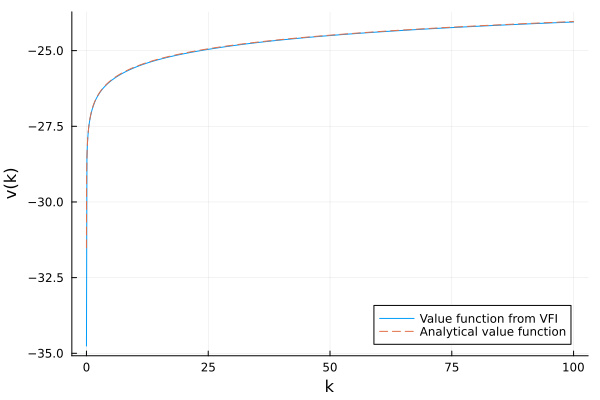

In [5]:
function v_analytical(k::Float64)
    return log(1 - α * β) / (1 - β) + (α * log(α * β)) / (1 - α)*(1 / (1 - β) - 1 / (1 - α * β)) + 1 / (1 - α * β) * log(k^α)
end

using Plots

value_F = LinearInterpolation(kgrid, vguess_V)
kfine_V = range(kmin, kmax, length=5_001)

plot(kfine_V, value_F.(kfine_V),
    label = "Value function from VFI",
    xlabel = "k", ylabel = "v(k)")

plot!(kfine_V, v_analytical.(kfine_V),
    label = "Analytical value function",
    linestyle = :dash)

Here, you can see that the two value functions are virtually completely indistinguishable, indicating that the numerical solution is very accurate. Let's see the policy function for $k^\prime$ has fared:

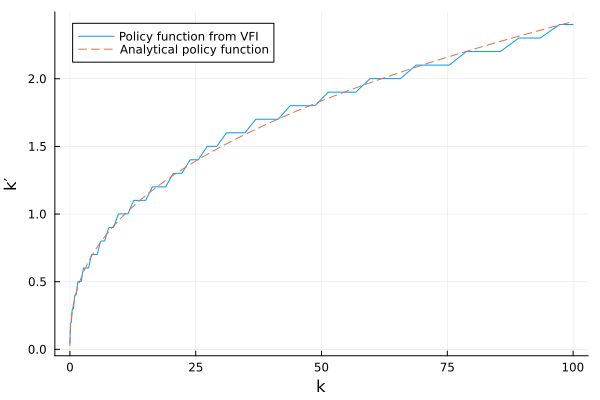

In [6]:
pol_F = LinearInterpolation(kgrid, pol_V)

plot(kfine_V, pol_F.(kfine_V),
    label = "Policy function from VFI",
    xlabel = "k", ylabel = "k′")

pol_F_analytical(k::Float64) = α * β * k^α

plot!(kfine_V, pol_F_analytical.(kfine_V),
    label = "Analytical policy function",
    linestyle = :dash)

While the numerical policy function for $k^\prime$ looks reasonably close to the true policy function, there is alot of jaggedness. This is due to using linear interpolation to approximate the value function between gridpoints, which produces non-differentiable kinks at each gridpoint. In fact, there is a formal way of assessing how accurate the policy function.

# 4. Euler Residuals
In equilibrium, we know that the policy function for next period's capital, $k^\prime = g(k)$, must satisfy the following inter-temporal optimality condition or the Euler equation:
$$
u_c(f(k) - k^\prime) = \beta f_k (k^\prime) u_c(f(k^\prime) - k^{\prime\prime})
$$
or written in a way that makes the functional dependencies clear:
$$
u_c[f(k) - g(k)] = \beta f_k (g(k)) u_c[f(g(k)) - g(g(k))]
$$
where $u_c(c) = 1/c$ and $f_k(k) = \alpha k^{\alpha-1}$.

If our numerical policy function was exactly correct, then the Euler equation should hold exactly at every single point across the state-space. Thus, one way to assess our solution's accuracy is to substitute the policy function in at many points (especially off-grid), compute the residuals at each point, i.e. 
$$
\text{euler-residual}(k_i) = \frac{u_c[f(k_i) - g(k_i)]}{\beta f_k (g(k_i)) u_c[f(g(k_i)) - g(g(k_i))]} - 1
$$
and assess the distribution of the absolute value of the errors in log-10 space.

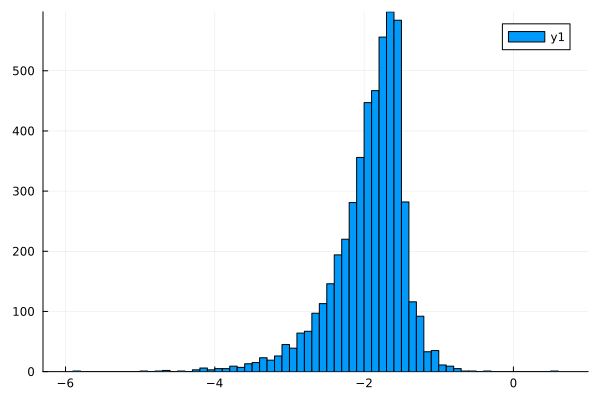

In [7]:
using Statistics

function u_c(c::Float64)
    return 1/c
end

function f_k(k::Float64)
    return α * k^(α - 1)
end

function compute_euler_residual(k::Float64)
    k′ = pol_F(k)
    c = f(k) - k′
    LHS = u_c(c)
    k′′ = pol_F(k′)
    c′ = f(k′) - k′′
    RHS = β * f_k(k′) * u_c(c′)
    return log10(abs(LHS/RHS - 1))
end

errors_V = compute_euler_residual.(kfine_V)

histogram(errors_V)


In [ ]:
mean(errors_V)

While not absolutely terrible, a mean residual residual of greater than $-2$ is not ideal, especially in a well-behaved problem like this one. One way to improve the accuracy of our solution is to increase the number of gridpoints. A more efficient strategy would be to observe that both the value function and the policy function are quite smooth in $k$, suggesting that interpolating with cubic splines may lead to higher accuracy.

Below is my Julia code for solving the model with cubic splines, and written in a way that is optimized for Julia.

Iteration: 50, Error: 0.14794546250262286
Iteration: 100, Error: 0.019216013795155362
Iteration: 150, Error: 0.0024958872001299426
Iteration: 200, Error: 0.00032418028955305545
Iteration: 250, Error: 4.2106414163356476e-5
Iteration: 300, Error: 5.469025023074892e-6
Iteration: 350, Error: 7.103486616699684e-7
Iteration: 400, Error: 9.226420871755181e-8
Iteration: 450, Error: 1.1983821934791195e-8


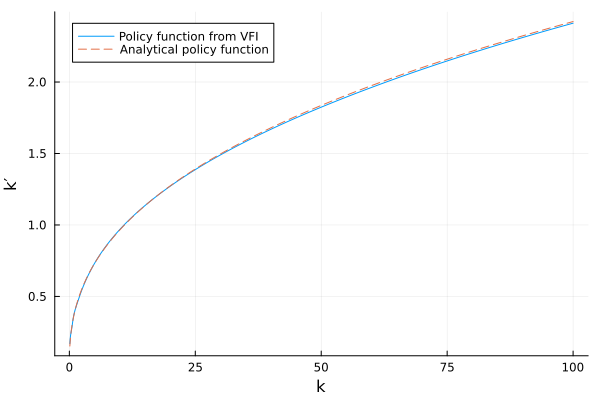

In [ ]:
using Interpolations
using LinearAlgebra
using Optim
using Parameters

@with_kw struct Params{F1, F2, F3, F4}
    #Economic parameters
    β::Float64  # Discount factor
    α::Float64   # Capital share in production
    #Grid
    kmin::Float64
    kmax::Float64
    nk::Int64
    kgrid::AbstractVector{<:Real}
    tol::Float64
    max_iter::Int64
    #Functions
    u::F1
    f::F2
    u_c::F3
    f_k::F4
end

function make_params(; β = 0.96, α = 0.4, kmin = 1e-3, kmax = 100.0, nk = 501, tol = 1e-6, max_iter = 600)
    kgrid = range(kmin, kmax, length=nk)
    f(k) = k^α
    u(c) = c > 0.0 ? log(c) : -1e10
    u_c(c) = c > 0.0 ? 1/c : 0.0
    f_k(k) = α * k^(α - 1)
    return Params(β, α, kmin, kmax, nk, kgrid, tol, max_iter, u, f, u_c, f_k)
end

function bellman_operator(vguess_V::Vector{Float64}, p::Params)
    @unpack β, α, kgrid, u, f, kmin = p

    vguess_F = CubicSplineInterpolation(kgrid, vguess_V)
    Tv_V = zeros(length(kgrid))
    pol_V = zeros(length(kgrid))
    
    for i in eachindex(kgrid)
        k = kgrid[i]
        results = optimize(k′ -> -u(f(k) - k′) - β * vguess_F(k′), kmin, f(k))
        Tv_V[i] = -results.minimum
        pol_V[i] = results.minimizer
    end

    return Tv_V, pol_V
end

function solve_model_vfi(p::Params)
    @unpack kgrid, u, f, tol, max_iter = p

    pol_V = zeros(length(kgrid))
    vguess_V = u.(f.(kgrid))

    iiter = 0 

    while iiter < max_iter
        iiter += 1

        vnew_V, pol_V = bellman_operator(vguess_V, p)

        diff = norm(vnew_V - vguess_V, Inf)
        if iiter % 50 == 0
            println("Iteration: $iiter, Error: $diff")
        end
        if diff < tol
            break
        end

        vguess_V = copy(vnew_V)
    end

    return vguess_V, pol_V
end

p = make_params(nk = 1_001, tol = 1e-8, kmin = 0.1)

value_V, pol_V = solve_model_vfi(p)

using Plots
kfine_V = range(p.kmin, p.kmax, length= 5_001)

pol_F = CubicSplineInterpolation(p.kgrid, pol_V)

function pol_F_analytical(k::Float64; p = p::Params)
    @unpack α, β, f = p
    return α * β * f(k)
end

plot(kfine_V, pol_F.(kfine_V),
    label = "Policy function from VFI",
    xlabel = "k", ylabel = "k′")

plot!(kfine_V, pol_F_analytical.(kfine_V),
    label = "Analytical policy function",
    linestyle = :dash)

Interpolating with cubic splines has dramatically improved the fit between the numerical policy function and the true policy function to the point where they are close to being visually indistinguishable. Indeed, here's the new distribution of the Euler residuals:


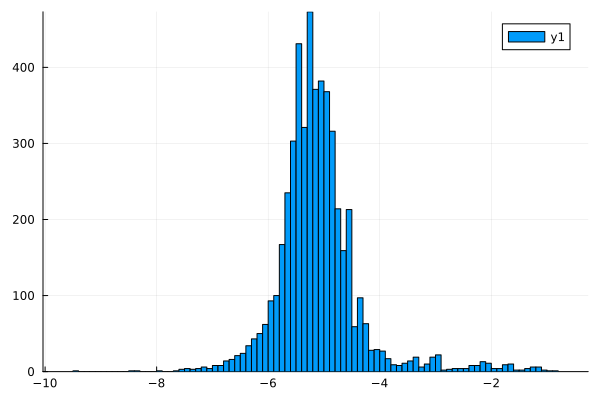

In [9]:
function compute_euler_residual(k::Float64; p = p::Params)
    @unpack β, α, f, u_c, f_k = p
    k′ = pol_F(k)
    c = f(k) - k′
    LHS = u_c(c)
    k′′ = pol_F(k′)
    c′ = f(k′) - k′′
    RHS = β * f_k(k′) * u_c(c′)
    return log10(abs(LHS/RHS - 1))
end

errors = compute_euler_residual.(kfine_V)

histogram(errors)

In [10]:
mean(errors)

-5.102943115284783

When using cubic splines, the mean Euler residual has dramatically decreased from -1.9 (or about $1.3\%$ average error in the Euler equation) to -5.1 (or only about $0.0008\%$ error)!